<a href="https://colab.research.google.com/github/awaiskhan005/DATA-SCIENCE-AND-AI-/blob/main/ETH_USD_PREDICTION_with_indicators.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import datetime as dt
!pip install pandas_ta # install the missing module
import pandas_ta as ta
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, Dropout, Input, Activation
from keras.optimizers import Adam

# Fetch Ethereum (ETH-USD) data from Yahoo Finance

In [ ]:
data = yf.download(tickers='ETH-USD', start='2019-01-01', end=dt.datetime.now())

[*********************100%***********************]  1 of 1 completed


# Adding indicators (RSI and EMAs)

In [ ]:
data['RSI'] = ta.rsi(data['Close'], length=15)
data['EMAF'] = ta.ema(data['Close'], length=15)
data['EMAM'] = ta.ema(data['Close'], length=100)
data['EMAS'] = ta.ema(data['Close'], length=200)

In [ ]:
# Drop rows with missing values
data.dropna(inplace=True)

data['TargetNextDayClose'] = data['Adj Close'].shift(-1)
data.dropna(inplace=True)

In [ ]:
data_set = data[['Open', 'High', 'Low', 'Adj Close', 'RSI', 'EMAF', 'EMAM', 'EMAS', 'TargetNextDayClose']]

In [ ]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
data_set_scaled = scaler.fit_transform(data_set)

In [ ]:
X = []
y = []
backcandles = 30
for i in range(backcandles, data_set_scaled.shape[0]):
    X.append(data_set_scaled[i - backcandles:i, :-1])
    y.append(data_set_scaled[i, -1])

X = np.array(X)
y = np.array(y)


# Split data

In [ ]:

split_limit = int(len(X) * 0.8)
X_train, X_test = X[:split_limit], X[split_limit:]
y_train, y_test = y[:split_limit], y[split_limit:]

In [ ]:
# Build LSTM model
lstm_input = Input(shape=(backcandles, X.shape[2]), name='lstm_input')
x = LSTM(150, name='first_layer')(lstm_input)
x = Dense(1, name='dense_layer')(x)
output = Activation('linear', name='output')(x)

model = Model(inputs=lstm_input, outputs=output)
adam = Adam()
model.compile(optimizer=adam, loss='mse')

# Train the model
model.fit(X_train, y_train, batch_size=15, epochs=50, shuffle=True, validation_data=(X_test, y_test))
y_pred = model.predict(X_test)

Epoch 1/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - loss: 0.0125 - val_loss: 0.0015
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.0014 - val_loss: 0.0010
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0013 - val_loss: 8.4492e-04
Epoch 5/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 6/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 9.3734e-04 - val_loss: 9.7991e-04
Epoch 7/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - loss: 9.2077e-04 - val_loss: 0.0017
Epoch 8/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 9.4269e-04 - val_loss: 8.3567e-04
Epoch 9/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 8.9800e-04 - val_loss: 7.4783e-04
Epoch 10/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - loss: 8.5346e-04 - val_loss: 0.0010
Epoch 11/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 8.1431e-04 - val_loss: 7.4477e-

In [ ]:
predicted_prices = np.zeros((len(y_pred), data_set_scaled.shape[1]))
predicted_prices[:, -1] = y_pred.flatten()
predicted_prices = scaler.inverse_transform(predicted_prices)[:, -1]


In [ ]:
y_test_actual = np.zeros((len(y_test), data_set_scaled.shape[1]))
y_test_actual[:, -1] = y_test
y_test_actual = scaler.inverse_transform(y_test_actual)[:, -1]

# Plot actual vs predicted Ethereum prices

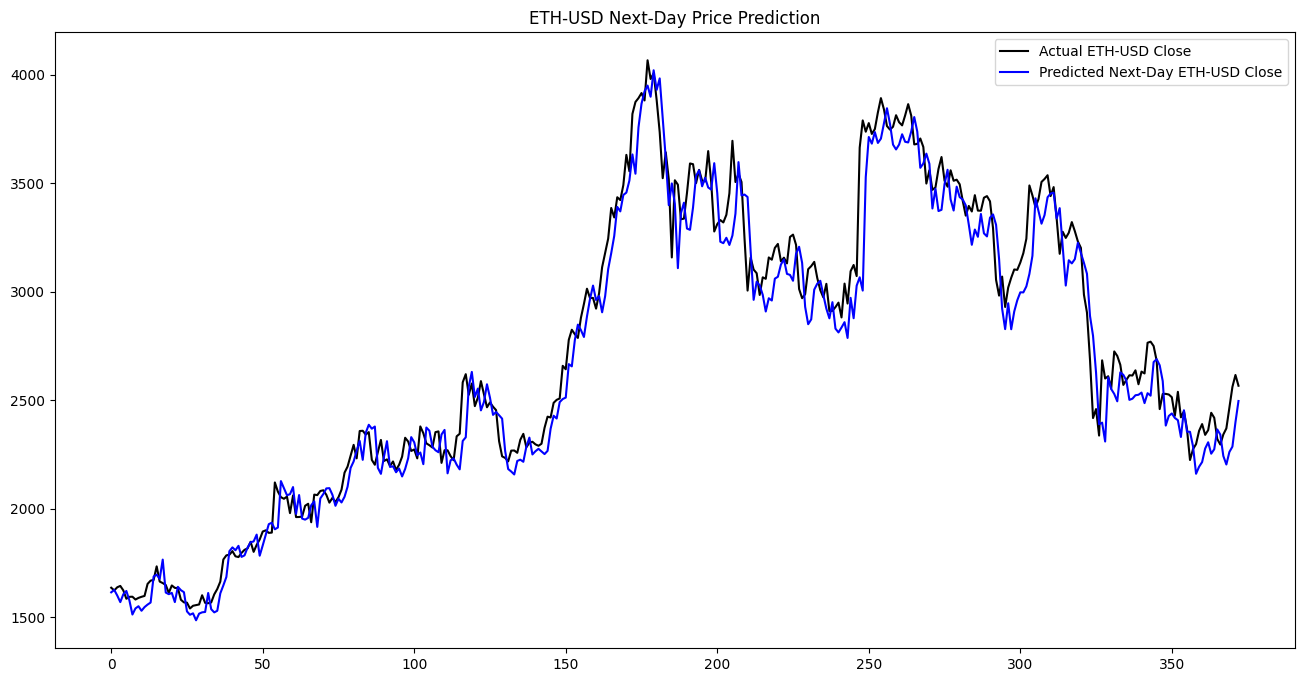

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(y_test_actual, color='black', label='Actual ETH-USD Close')
plt.plot(predicted_prices, color='blue', label='Predicted Next-Day ETH-USD Close')
plt.title('ETH-USD Next-Day Price Prediction')
plt.legend()
plt.show()

In [ ]:
last_data = data_set_scaled[-backcandles:, :-1]
last_data = np.array([last_data])

predicted_next_day_scaled = model.predict(last_data)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


# Inverse transform the predicted next-day price

In [ ]:
next_day_price_scaled = np.zeros((1, data_set_scaled.shape[1]))
next_day_price_scaled[0, -1] = predicted_next_day_scaled
predicted_next_day_price = scaler.inverse_transform(next_day_price_scaled)[:, -1][0]

print(f"Predicted ETH-USD price for the next day: ${predicted_next_day_price:.2f}")

Predicted ETH-USD price for the next day: $2549.97


<ipython-input-19-745d72995eaf>:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  next_day_price_scaled[0, -1] = predicted_next_day_scaled
